In [ ]:
!pip install kaggle

In [ ]:
import csv
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
files.upload() #Kaggle.json 

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alfizahra","key":"915cfd9b088920df70bb94962d42556c"}'}

Kaggle Edits


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Downloading file from Kaggle Dataset

In [ ]:
!kaggle datasets download -d moltean/fruits

 99% 750M/760M [00:09<00:00, 84.2MB/s]
100% 760M/760M [00:09<00:00, 87.9MB/s]


In [ ]:
import zipfile
local_zip = '/content/fruits.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

Import library


In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
import cv2

# import model 
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense

#import warnings
import warnings
warnings.filterwarnings('ignore')

import os

Load and check data

In [ ]:
training_dir = '/content/fruits-360/Training/'
test_dir =  '/content/fruits-360/Test/'


Modeling

In [ ]:
fruittype = glob(training_dir + '/*' )
sumoftype = len(fruittype)

In [ ]:
model = Sequential()
model.add(Conv2D(32,(3,3), input_shape = (150, 150, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(sumoftype)) 
model.add(Activation("softmax"))

In [ ]:
model.compile(loss = "categorical_crossentropy",
              optimizer = "rmsprop",
              metrics = ["accuracy"])

In [ ]:
epochs = 100
batch_size = 32

training_datagen = ImageDataGenerator(rescale= 1./255,
                                      width_shift_range = 0.2,
                                      height_shift_range = 0.2,
                                      shear_range = 0.2,
                                      horizontal_flip=True,
                                      zoom_range = 0.2,
                                      fill_mode = 'nearest',
                                      rotation_range = 40)

test_datagen = ImageDataGenerator(rescale= 1./255)

In [ ]:
train_generator = training_datagen.flow_from_directory(
        training_dir, 
        target_size = (150, 150),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

test_generator = test_datagen.flow_from_directory(
        test_dir, 
        target_size = (150, 150),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


Fit the model

In [ ]:
history = model.fit_generator(
    generator = train_generator,
    steps_per_epoch = 1600 // batch_size,
    epochs = epochs,
    validation_data = test_generator,
    validation_steps = 800 // batch_size)

Epoch 1/100
50/50 [==============================] - 75s 1s/step - loss: 6.1051 - accuracy: 0.0245 - val_loss: 4.6411 - val_accuracy: 0.0450
Epoch 2/100
50/50 [==============================] - 60s 1s/step - loss: 4.2604 - accuracy: 0.0694 - val_loss: 4.5290 - val_accuracy: 0.0725
Epoch 3/100
40/50 [=======================>......] - ETA: 10s - loss: 3.7141 - accuracy: 0.1244

Evaluate the model

Loss

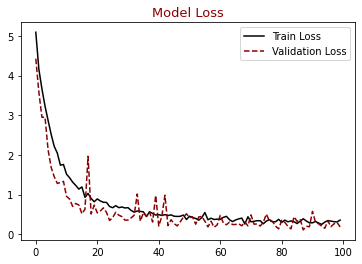

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label = "Train Loss", color = "black")
plt.plot(history.history["val_loss"], label = "Validation Loss", color = "darkred", linestyle="dashed",markeredgecolor = "purple", markeredgewidth = 2)
plt.title("Model Loss", color = "darkred", size = 13)
plt.legend()
plt.show()

Accuracy

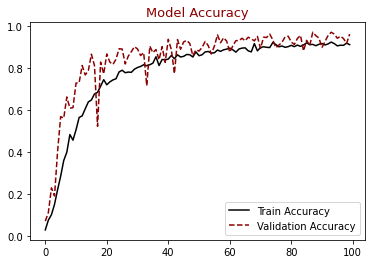

In [ ]:
plt.figure()
plt.plot(history.history["accuracy"],label = "Train Accuracy", color = "black")
plt.plot(history.history["val_accuracy"], label = "Validation Accuracy", color = "darkred", linestyle="dashed",markeredgecolor = "purple", markeredgewidth = 2)
plt.title("Model Accuracy", color = "darkred", size = 13)
plt.legend()
plt.show()

Model TF to TFLite

In [ ]:
RPS_SAVED_MODEL = "rps_saved_model"

In [ ]:
tf.saved_model.save(model, RPS_SAVED_MODEL)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: rps_saved_model/assets


In [ ]:
%%bash -s $RPS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['conv2d_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 150, 150, 3)
      name: serving_default_conv2d_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['activation_4'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 131)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [ ]:
loaded = tf.saved_model.load(RPS_SAVED_MODEL)

In [ ]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'conv2d_input': TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='conv2d_input')})
{'activation_4': TensorSpec(shape=(None, 131), dtype=tf.float32, name='activation_4')}


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(RPS_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

In [ ]:
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)